# Prepare Paul15 Data

In [2]:
import scanpy as sc

paul_data = sc.datasets.paul15()
paul_data

AnnData object with n_obs × n_vars = 2730 × 3451
    obs: 'paul15_clusters'
    uns: 'iroot'

In [3]:
paul_data.to_df().head()

,0610007L01Rik,0610009O20Rik,0610010K14Rik,0910001L09Rik,1100001G20Rik,1110002B05Rik,1110004E09Rik,1110007A13Rik,1110007C09Rik,1110013L07Rik,...,hnRNP A2/B1,mFLJ00022,mKIAA0007,mKIAA0569,mKIAA0621,mKIAA1027,mKIAA1575,mKIAA1994,rp9,slc43a2
W31105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
W31106,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,7.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0
W31107,1.0,0.0,3.0,1.0,0.0,0.0,2.0,3.0,0.0,0.0,...,17.0,0.0,3.0,2.0,0.0,4.0,1.0,2.0,3.0,0.0
W31108,1.0,0.0,3.0,1.0,0.0,3.0,1.0,2.0,0.0,1.0,...,18.0,2.0,2.0,0.0,0.0,6.0,0.0,0.0,2.0,0.0
W31109,0.0,3.0,8.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,...,10.0,1.0,5.0,0.0,0.0,6.0,2.0,5.0,5.0,0.0


In [4]:
# Preprocessing. I am following mostly the scanpy docs

custom_preprocessing = False
if custom_preprocessing:
    # TODO: quality control metrics
    # I first need to inspect, which genes i want to use here. I do not know what information the gene label names give.

    # filter out cells and gene that are poorly expressed
    # TODO: maybe use stricter thresholds
    sc.pp.filter_cells(paul_data, min_genes=100)
    sc.pp.filter_genes(paul_data, min_cells=3)

    # Filters out dublets
    sc.pp.scrublet(paul_data)

    # normalize counts
    paul_data.layers["counts"] = paul_data.X.copy()
    sc.pp.normalize_total(paul_data)
    sc.pp.log1p(paul_data)

    # Feature selection, by only considering highly variable genes
    # TODO: which threshold to use? Should I use seurat_v3 or cell_ranger? 
    # Also consider preprocessing step from single best practices that uses deviance
    sc.pp.highly_variable_genes(paul_data, n_top_genes=1500, flavor="seurat")
    sc.pl.highly_variable_genes(paul_data)

    # Dispersion is a kind of normalized variance. 
    # So we can compare the variance of different genes, even if they alternate in their magnitude
else:
    sc.pp.recipe_zheng17(paul_data)


/home/atr0x/Documents/UNI/WS2025/BachelorArbeit/GAE-gene-interactions/.venv/lib/python3.12/site-packages/scanpy/preprocessing/_recipes.py:187: FutureWarning: Use sc.pp.highly_variable_genes instead
  filter_result = filter_genes_dispersion(


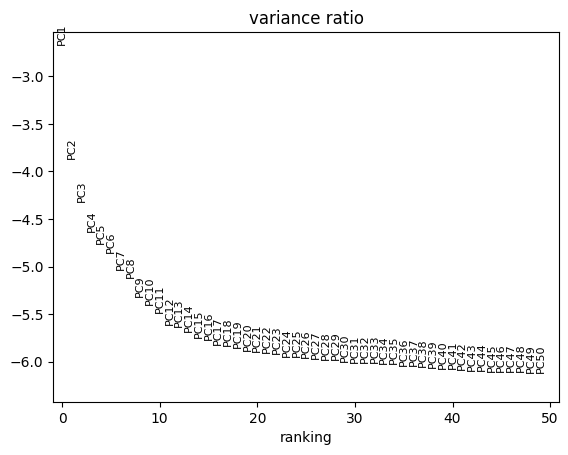

In [5]:
# Dimensionality reduction, that will be used for clustering methods
sc.tl.pca(paul_data)
sc.pl.pca_variance_ratio(paul_data, n_pcs=50, log=True)

/home/atr0x/Documents/UNI/WS2025/BachelorArbeit/GAE-gene-interactions/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


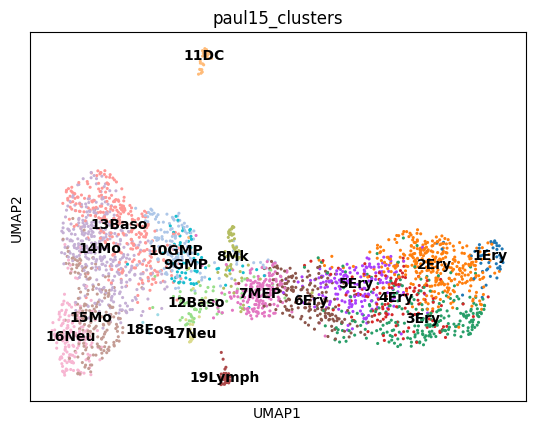

In [6]:
n_pcs = 20 # Seems like a good fit
sc.pp.neighbors(paul_data, n_pcs=n_pcs)
sc.tl.umap(paul_data)
sc.pl.umap(
    paul_data,
    color="paul15_clusters",
    size=20,
    legend_loc="on data"
)

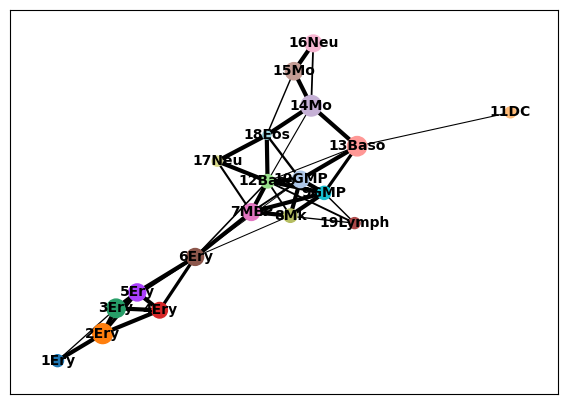

In [7]:
# calculating differentiation map
sc.tl.paga(paul_data, groups="paul15_clusters")
sc.pl.paga(paul_data, threshold=0.2, edge_width_scale=0.4)

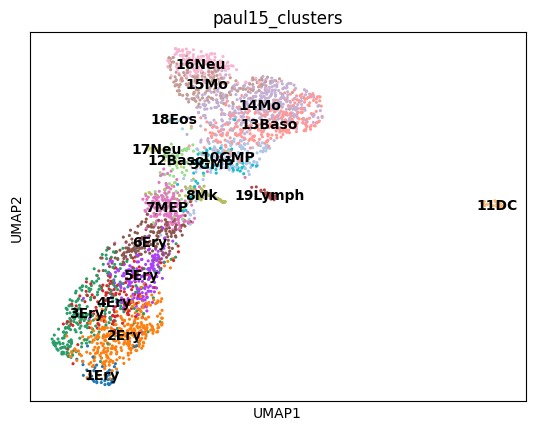

In [8]:
# Recompute embedding with paga positions.
sc.tl.umap(paul_data, init_pos='paga')
sc.pl.umap(
    paul_data,
    color="paul15_clusters",
    size=20,
    legend_loc="on data"
)

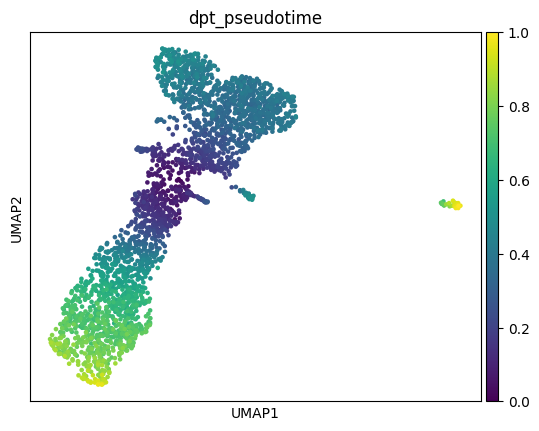

In [9]:
# Compute pseudo time.
# iroot is already set by paul15 dataset
sc.tl.dpt(paul_data)
sc.pl.umap(paul_data, color=["dpt_pseudotime"])

# TODO: use paga_compare and matplotlib axes, to make nicer plots. Plot them all next to each other
# TODO: also inspecting gene changes could be later useful for evaluation 

/tmp/ipykernel_25866/354487863.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_pseudotime = paul_data.obs.groupby('paul15_clusters')['dpt_pseudotime'].min()


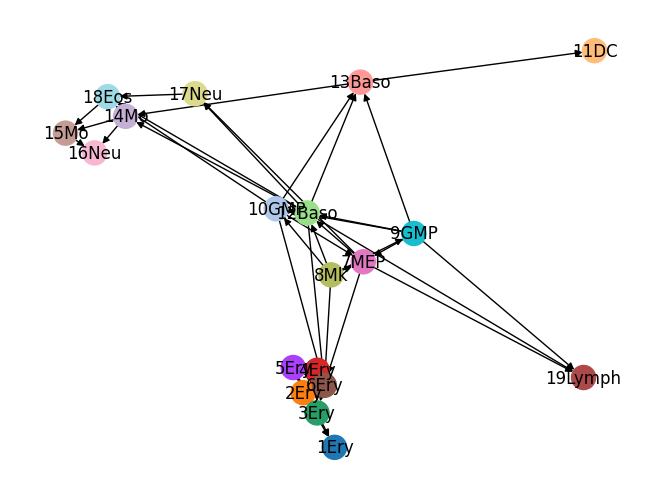

In [ ]:
import networkx as nx

cluster_labels = paul_data.obs["paul15_clusters"].dtype.categories
paul_data.uns["paul15_clusters_labels"] = cluster_labels.values

cluster_pseudotime = paul_data.obs.groupby('paul15_clusters')['dpt_pseudotime'].min()

# Extract paga network
paga_adjacency_matrix = paul_data.uns["paga"]["connectivities"].toarray().copy()

paga_graph = nx.DiGraph()
paga_graph.add_nodes_from(cluster_labels)

paga_threshold = 0.2

for i, node_label in enumerate(cluster_labels):
    for j, neighbor_label in enumerate(cluster_labels):
        if paga_adjacency_matrix[i, j] >= paga_threshold:
            node_min_pt = cluster_pseudotime[node_label]
            neighbor_min_pt = cluster_pseudotime[neighbor_label]

            # only keep those edges, where the node is younger, than the neighbors
            if node_min_pt <= neighbor_min_pt:
                paga_graph.add_edge(node_label, neighbor_label)
            else:
                paga_graph.add_edge(neighbor_label, node_label)


nx.draw(paga_graph, with_labels=True, node_color=paul_data.uns["paul15_clusters_colors"])
paul_data.uns["differentiation_graph"] = nx.to_pandas_adjacency(paga_graph)

In [18]:
root = [node for node, degree in paga_graph.in_degree() if degree == 0][0]
paul_data.uns["differentiation_graph_root"] = root

In [14]:
# TODO: GRN
# Actually, maybe first just load human_mice_grn make it binary (not directed) and use that for comparison

In [ ]:
paul_data.write_h5ad("../data/paul15_processed.h5ad")